In [49]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import pickle

# Load data
print("Loading data...")
df = pd.read_csv('men_2026_matchups_training.csv')

# Filter for Final Four and Championship rounds only
print(f"\nTotal samples in dataset: {len(df)}")
df_filtered = df[df['round'].isin(['Final Four', 'Championship'])].copy()
print(f"Final Four + Championship samples: {len(df_filtered)}")
print(f"Round breakdown:\n{df_filtered['round'].value_counts()}")

# Features
features = [
    '5man_bpm', 'kenpom_rtg', '3man_bpm', 'wab', 'torvik_rtg', '5man_dbpm',
    '5man_obpm', 'torvik_def', 'kenpom_def', 'torvik_off', 'kenpom_off',
    '3man_obpm', 'def_experience_impact', 'experience_weighted_production',
    '3man_dbpm', 'def_lineup_depth_quality', 'lineup_depth_quality',
    'four_factors_composite', 'def_four_factors_composite', 'size', 'efgd_pct',
    'efg_pct', 'def_effective_possession_rate', '2p_pct', 'def_dunk_share',
    'size_speed_index', 'def_size_speed_index', 'height', 'def_close2_fg_pct',
    'off_dunk_share', 'effective_possession_rate', 'elite_outcome_probability',
    'off_close2_fg_pct', 'perimeter_efficiency', 'def_3pt_fg_pct', '2pd_pct',
    'def_perimeter_efficiency', '3pd_pct', 'off_3pt_fg_pct', 'blked_pct',
    'def_rim_efficiency', '3p_pct', 'assist_to_usage_ratio', 'rim_efficiency',
    'blk_pct', 'orb_pct', 'def_assist_suppression', 'block_efficiency',
    'bench_scoring_ratio', 'bench', 'def_far2_share', 'off_far2_share',
    'off_far2_fg_pct', 'drb_pct', 'free_throw_advantage', 'def_free_throw_advantage',
    'off_close2_share', 'off_3pt_share', 'rim_to_three_ratio', 'def_rim_to_three_ratio',
    'rotation_balance', 'shot_quality_variance', 'three_point_volume_efficiency',
    'def_three_point_volume_efficiency', 'drb_pct', 'top5_rebounding_concentration',
    'def_lineup_depth_quality'
]

# Prepare data
X = df_filtered[features].copy()
y = df_filtered['win'].copy()

# Handle missing values
print(f"\nMissing values before imputation: {X.isnull().sum().sum()}")
X = X.fillna(X.median())

# Train/test split
print("\n" + "="*70)
print("TRAIN/TEST SPLIT")
print("="*70)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.4, random_state=42, stratify=y
)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Train class distribution:\n{y_train.value_counts()}")
print(f"Test class distribution:\n{y_test.value_counts()}")

Loading data...

Total samples in dataset: 1254
Final Four + Championship samples: 60
Round breakdown:
round
Final Four      40
Championship    20
Name: count, dtype: int64

Missing values before imputation: 0

TRAIN/TEST SPLIT
Training samples: 36
Test samples: 24
Train class distribution:
win
0    18
1    18
Name: count, dtype: int64
Test class distribution:
win
1    12
0    12
Name: count, dtype: int64


In [50]:

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*70)
print("COMPARING REGULARIZATION TECHNIQUES")
print("="*70)

# Store results
results = {}


COMPARING REGULARIZATION TECHNIQUES


In [51]:
# ============================================================================
# 1. RIDGE REGRESSION (L2 regularization)
# ============================================================================
print("\n[1/5] Ridge Regression (L2 regularization)...")
print("     - Shrinks coefficients but keeps all features")

alphas = np.logspace(-4, 4, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

ridge_train_pred = (ridge_cv.predict(X_train_scaled) > 0.5).astype(int)
ridge_test_pred = (ridge_cv.predict(X_test_scaled) > 0.5).astype(int)

ridge_train_acc = accuracy_score(y_train, ridge_train_pred)
ridge_test_acc = accuracy_score(y_test, ridge_test_pred)

results['Ridge'] = {
    'model': ridge_cv,
    'train_acc': ridge_train_acc,
    'test_acc': ridge_test_acc,
    'alpha': ridge_cv.alpha_,
    'coef': ridge_cv.coef_,
    'non_zero': np.sum(ridge_cv.coef_ != 0),
    'train_pred': ridge_train_pred,
    'test_pred': ridge_test_pred
}

print(f"     Best alpha: {ridge_cv.alpha_:.6f}")
print(f"     Train accuracy: {ridge_train_acc:.4f}")
print(f"     Test accuracy: {ridge_test_acc:.4f}")
print(f"     Non-zero coefficients: {results['Ridge']['non_zero']}")


[1/5] Ridge Regression (L2 regularization)...
     - Shrinks coefficients but keeps all features
     Best alpha: 613.590727
     Train accuracy: 0.7778
     Test accuracy: 0.6667
     Non-zero coefficients: 67


In [52]:
# ============================================================================
# 2. LASSO REGRESSION (L1 regularization)
# ============================================================================
print("\n[2/5] Lasso Regression (L1 regularization)...")
print("     - Performs feature selection by setting coefficients to zero")

alphas = np.logspace(-4, 1, 100)
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

lasso_train_pred = (lasso_cv.predict(X_train_scaled) > 0.5).astype(int)
lasso_test_pred = (lasso_cv.predict(X_test_scaled) > 0.5).astype(int)

lasso_train_acc = accuracy_score(y_train, lasso_train_pred)
lasso_test_acc = accuracy_score(y_test, lasso_test_pred)

results['Lasso'] = {
    'model': lasso_cv,
    'train_acc': lasso_train_acc,
    'test_acc': lasso_test_acc,
    'alpha': lasso_cv.alpha_,
    'coef': lasso_cv.coef_,
    'non_zero': np.sum(lasso_cv.coef_ != 0),
    'train_pred': lasso_train_pred,
    'test_pred': lasso_test_pred
}

print(f"     Best alpha: {lasso_cv.alpha_:.6f}")
print(f"     Train accuracy: {lasso_train_acc:.4f}")
print(f"     Test accuracy: {lasso_test_acc:.4f}")
print(f"     Non-zero coefficients: {results['Lasso']['non_zero']}")


[2/5] Lasso Regression (L1 regularization)...
     - Performs feature selection by setting coefficients to zero
     Best alpha: 0.120450
     Train accuracy: 0.7500
     Test accuracy: 0.7917
     Non-zero coefficients: 3


In [53]:

# ============================================================================
# 3. ELASTIC NET (L1 + L2 regularization)
# ============================================================================
print("\n[3/5] Elastic Net (L1 + L2 combined)...")
print("     - Combines Ridge and Lasso benefits")

alphas = np.logspace(-4, 1, 50)
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
elasticnet_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5,
                              max_iter=10000, random_state=42)
elasticnet_cv.fit(X_train_scaled, y_train)

elastic_train_pred = (elasticnet_cv.predict(X_train_scaled) > 0.5).astype(int)
elastic_test_pred = (elasticnet_cv.predict(X_test_scaled) > 0.5).astype(int)

elastic_train_acc = accuracy_score(y_train, elastic_train_pred)
elastic_test_acc = accuracy_score(y_test, elastic_test_pred)

results['ElasticNet'] = {
    'model': elasticnet_cv,
    'train_acc': elastic_train_acc,
    'test_acc': elastic_test_acc,
    'alpha': elasticnet_cv.alpha_,
    'l1_ratio': elasticnet_cv.l1_ratio_,
    'coef': elasticnet_cv.coef_,
    'non_zero': np.sum(elasticnet_cv.coef_ != 0),
    'train_pred': elastic_train_pred,
    'test_pred': elastic_test_pred
}

print(f"     Best alpha: {elasticnet_cv.alpha_:.6f}")
print(f"     Best L1 ratio: {elasticnet_cv.l1_ratio_:.4f}")
print(f"     Train accuracy: {elastic_train_acc:.4f}")
print(f"     Test accuracy: {elastic_test_acc:.4f}")
print(f"     Non-zero coefficients: {results['ElasticNet']['non_zero']}")


[3/5] Elastic Net (L1 + L2 combined)...
     - Combines Ridge and Lasso benefits
     Best alpha: 0.115140
     Best L1 ratio: 0.9900
     Train accuracy: 0.7500
     Test accuracy: 0.7500
     Non-zero coefficients: 3


In [54]:
# ============================================================================
# 4. LOGISTIC REGRESSION with L2 (Ridge)
# ============================================================================
print("\n[4/5] Logistic Regression with L2 (Ridge) penalty...")
print("     - Classification-specific model with L2 regularization")

Cs = np.logspace(-4, 4, 20)
logistic_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000,
                                  random_state=42)
# Manual CV to find best C
best_score = 0
best_C = None
for C in Cs:
    logistic_l2.set_params(C=C)
    logistic_l2.fit(X_train_scaled, y_train)
    score = logistic_l2.score(X_train_scaled, y_train)
    if score > best_score:
        best_score = score
        best_C = C

logistic_l2.set_params(C=best_C)
logistic_l2.fit(X_train_scaled, y_train)

logl2_train_pred = logistic_l2.predict(X_train_scaled)
logl2_test_pred = logistic_l2.predict(X_test_scaled)

logl2_train_acc = accuracy_score(y_train, logl2_train_pred)
logl2_test_acc = accuracy_score(y_test, logl2_test_pred)

results['Logistic_L2'] = {
    'model': logistic_l2,
    'train_acc': logl2_train_acc,
    'test_acc': logl2_test_acc,
    'C': best_C,
    'coef': logistic_l2.coef_[0],
    'non_zero': np.sum(logistic_l2.coef_[0] != 0),
    'train_pred': logl2_train_pred,
    'test_pred': logl2_test_pred
}

print(f"     Best C: {best_C:.6f}")
print(f"     Train accuracy: {logl2_train_acc:.4f}")
print(f"     Test accuracy: {logl2_test_acc:.4f}")
print(f"     Non-zero coefficients: {results['Logistic_L2']['non_zero']}")


[4/5] Logistic Regression with L2 (Ridge) penalty...
     - Classification-specific model with L2 regularization
     Best C: 1.623777
     Train accuracy: 1.0000
     Test accuracy: 0.7083
     Non-zero coefficients: 67


In [55]:
# ============================================================================
# 5. LOGISTIC REGRESSION with L1 (Lasso)
# ============================================================================
print("\n[5/5] Logistic Regression with L1 (Lasso) penalty...")
print("     - Classification-specific model with L1 regularization")

logistic_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000,
                                  random_state=42)
# Manual CV to find best C
best_score = 0
best_C = None
for C in Cs:
    logistic_l1.set_params(C=C)
    logistic_l1.fit(X_train_scaled, y_train)
    score = logistic_l1.score(X_train_scaled, y_train)
    if score > best_score:
        best_score = score
        best_C = C

logistic_l1.set_params(C=best_C)
logistic_l1.fit(X_train_scaled, y_train)

logl1_train_pred = logistic_l1.predict(X_train_scaled)
logl1_test_pred = logistic_l1.predict(X_test_scaled)

logl1_train_acc = accuracy_score(y_train, logl1_train_pred)
logl1_test_acc = accuracy_score(y_test, logl1_test_pred)

results['Logistic_L1'] = {
    'model': logistic_l1,
    'train_acc': logl1_train_acc,
    'test_acc': logl1_test_acc,
    'C': best_C,
    'coef': logistic_l1.coef_[0],
    'non_zero': np.sum(logistic_l1.coef_[0] != 0),
    'train_pred': logl1_train_pred,
    'test_pred': logl1_test_pred
}

print(f"     Best C: {best_C:.6f}")
print(f"     Train accuracy: {logl1_train_acc:.4f}")
print(f"     Test accuracy: {logl1_test_acc:.4f}")
print(f"     Non-zero coefficients: {results['Logistic_L1']['non_zero']}")


[5/5] Logistic Regression with L1 (Lasso) penalty...
     - Classification-specific model with L1 regularization
     Best C: 4.281332
     Train accuracy: 1.0000
     Test accuracy: 0.6667
     Non-zero coefficients: 24


In [56]:
# ============================================================================
# COMPARISON SUMMARY
# ============================================================================
print("\n" + "="*70)
print("COMPARISON SUMMARY")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Acc': [results[m]['train_acc'] for m in results.keys()],
    'Test Acc': [results[m]['test_acc'] for m in results.keys()],
    'Overfit (T-t)': [results[m]['train_acc'] - results[m]['test_acc'] for m in results.keys()],
    'Non-zero Coef': [results[m]['non_zero'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Test Acc', ascending=False)
print("\n" + comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 Best model by test accuracy: {best_model_name}")


COMPARISON SUMMARY

      Model  Train Acc  Test Acc  Overfit (T-t)  Non-zero Coef
      Lasso   0.750000  0.791667      -0.041667              3
 ElasticNet   0.750000  0.750000       0.000000              3
Logistic_L2   1.000000  0.708333       0.291667             67
      Ridge   0.777778  0.666667       0.111111             67
Logistic_L1   1.000000  0.666667       0.333333             24

🏆 Best model by test accuracy: Lasso


In [57]:
# ============================================================================
# DETAILED RESULTS FOR EACH MODEL
# ============================================================================
print("\n" + "="*70)
print("DETAILED RESULTS")
print("="*70)

for model_name in results.keys():
    print(f"\n{'─'*70}")
    print(f"{model_name.upper()}")
    print(f"{'─'*70}")

    res = results[model_name]

    print(f"\nTrain Accuracy: {res['train_acc']:.4f}")
    print(f"Test Accuracy:  {res['test_acc']:.4f}")
    print(f"Overfitting:    {res['train_acc'] - res['test_acc']:.4f}")
    print(f"Non-zero coef:  {res['non_zero']}/{len(features)}")

    print("\nTest Set Confusion Matrix:")
    print(confusion_matrix(y_test, res['test_pred']))

    # Top features
    feature_coefs = pd.DataFrame({
        'feature': features,
        'coefficient': res['coef'],
        'abs_coefficient': np.abs(res['coef'])
    }).sort_values('abs_coefficient', ascending=False)

    print(f"\nTop 10 Features:")
    for idx, row in feature_coefs.head(10).iterrows():
        print(f"  {row['feature']}: {row['coefficient']:.6f}")


DETAILED RESULTS

──────────────────────────────────────────────────────────────────────
RIDGE
──────────────────────────────────────────────────────────────────────

Train Accuracy: 0.7778
Test Accuracy:  0.6667
Overfitting:    0.1111
Non-zero coef:  67/67

Test Set Confusion Matrix:
[[8 4]
 [4 8]]

Top 10 Features:
  wab: 0.011557
  5man_bpm: 0.009611
  kenpom_rtg: 0.008887
  torvik_rtg: 0.008857
  3man_bpm: 0.007981
  kenpom_def: 0.006738
  torvik_def: 0.006575
  blk_pct: -0.006514
  5man_dbpm: 0.006457
  drb_pct: 0.006022

──────────────────────────────────────────────────────────────────────
LASSO
──────────────────────────────────────────────────────────────────────

Train Accuracy: 0.7500
Test Accuracy:  0.7917
Overfitting:    -0.0417
Non-zero coef:  3/67

Test Set Confusion Matrix:
[[10  2]
 [ 3  9]]

Top 10 Features:
  wab: 0.147434
  5man_bpm: 0.025857
  blk_pct: -0.008582
  3man_bpm: 0.000000
  kenpom_rtg: 0.000000
  5man_dbpm: 0.000000
  torvik_rtg: 0.000000
  torvik_def: 


GENERATING VISUALIZATIONS
✓ Visualization saved: regularization_comparison.png
✓ Visualization saved: accuracy_comparison.png


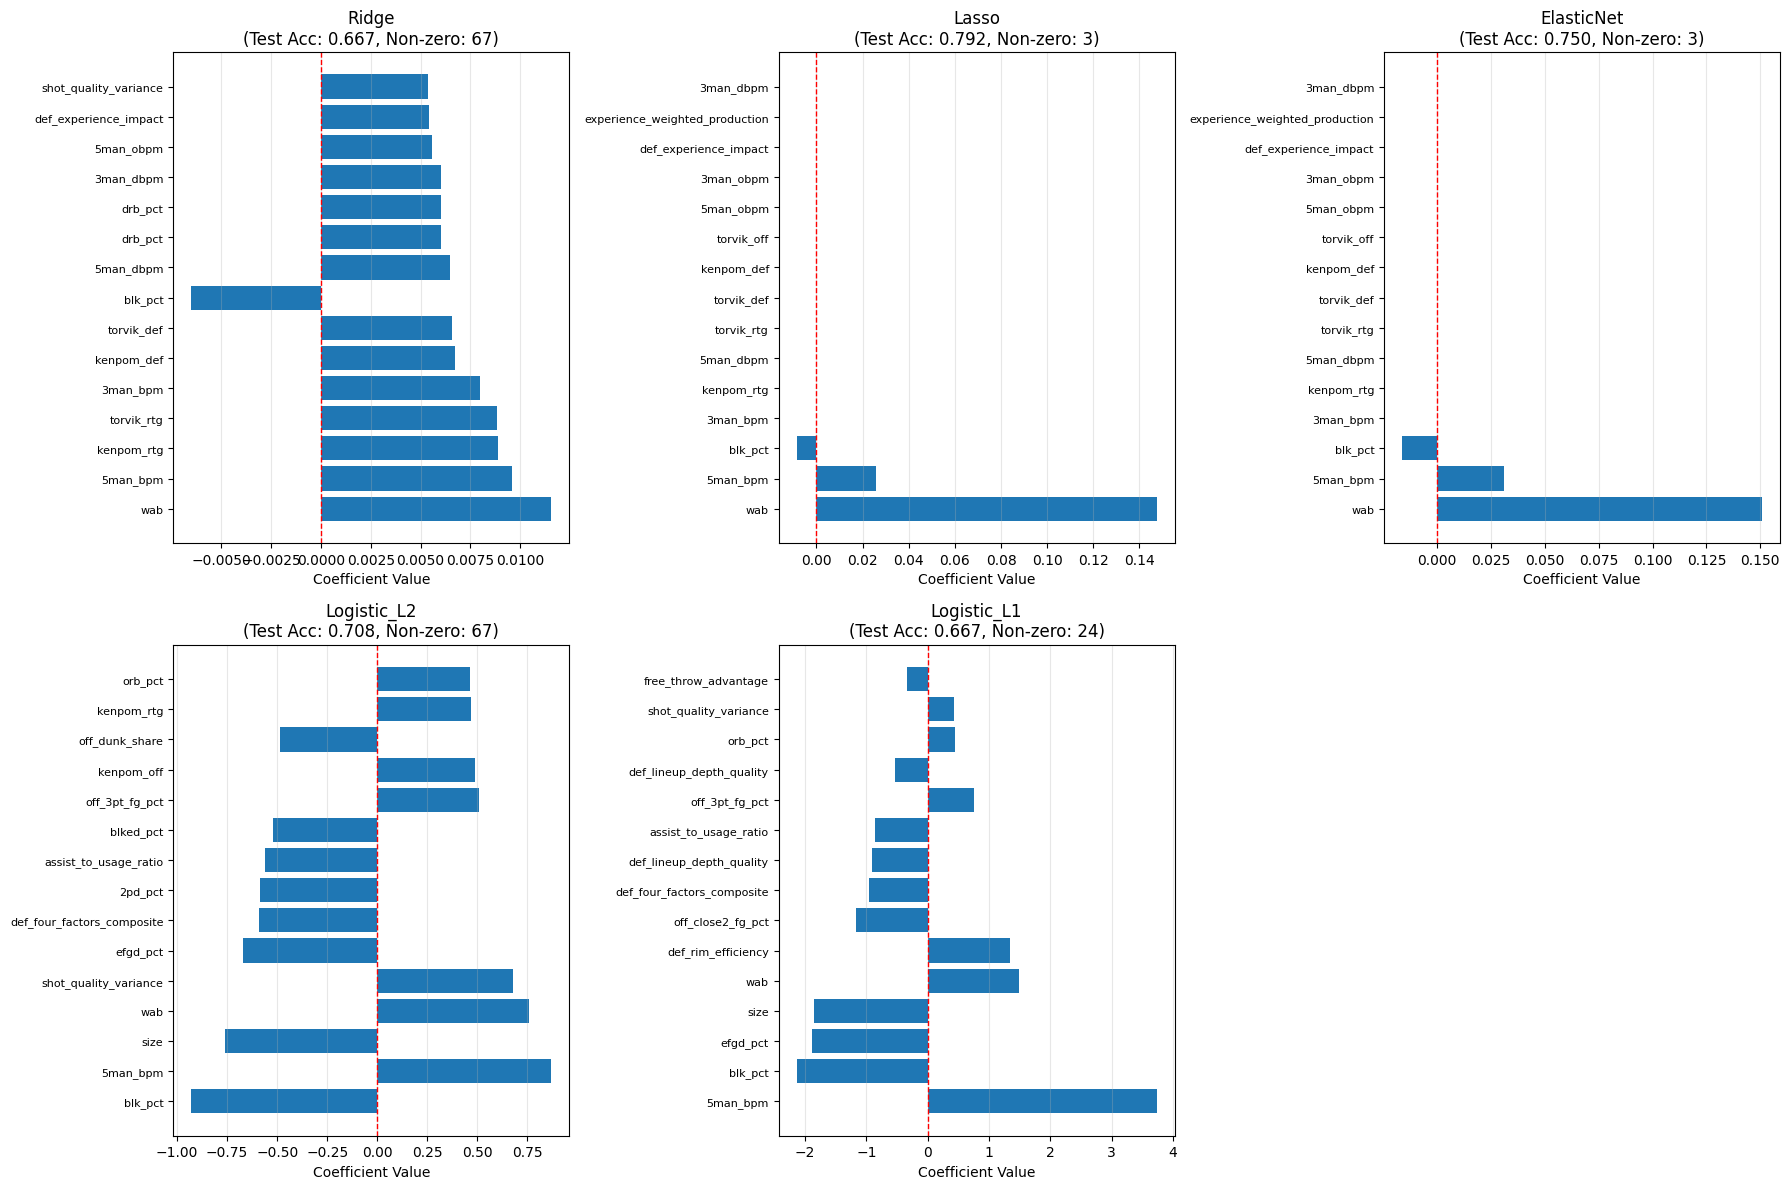

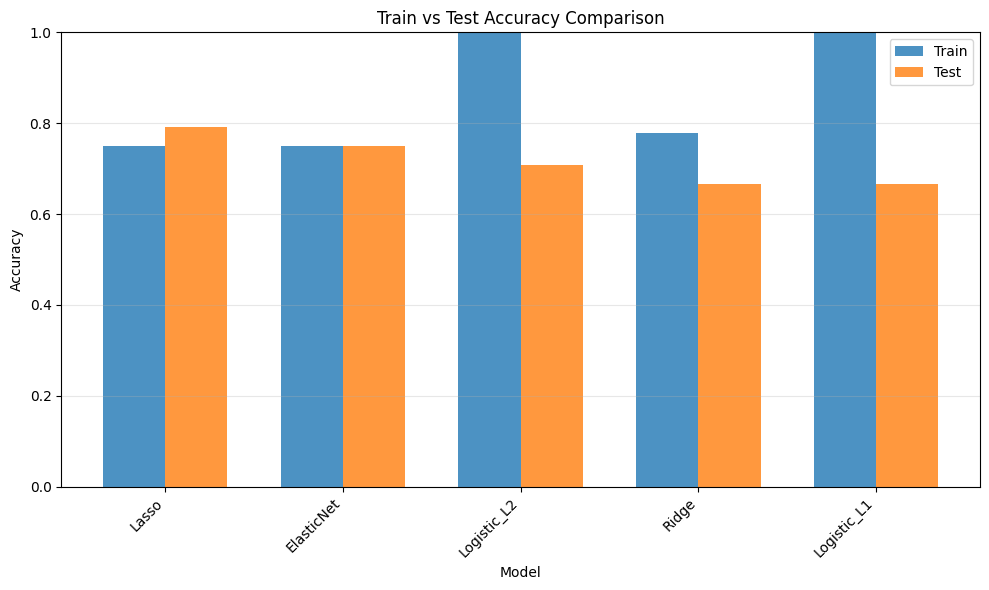

In [58]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, model_name in enumerate(results.keys()):
    res = results[model_name]

    # Get top 15 features
    feature_coefs = pd.DataFrame({
        'feature': features,
        'coefficient': res['coef']
    }).sort_values('coefficient', key=abs, ascending=False).head(15)

    axes[idx].barh(range(len(feature_coefs)), feature_coefs['coefficient'])
    axes[idx].set_yticks(range(len(feature_coefs)))
    axes[idx].set_yticklabels(feature_coefs['feature'], fontsize=8)
    axes[idx].set_xlabel('Coefficient Value')
    axes[idx].set_title(f'{model_name}\n(Test Acc: {res["test_acc"]:.3f}, Non-zero: {res["non_zero"]})')
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=1)
    axes[idx].grid(axis='x', alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('regularization_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: regularization_comparison.png")

# Performance comparison plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(len(results))
width = 0.35

ax.bar(x - width/2, comparison_df['Train Acc'], width, label='Train', alpha=0.8)
ax.bar(x + width/2, comparison_df['Test Acc'], width, label='Test', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Train vs Test Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved: accuracy_comparison.png")

In [59]:
# ============================================================================
# LASSO PREDICTIONS ON ENTIRE DATASET
# ============================================================================
print("\n" + "="*70)
print("LASSO PREDICTIONS ON ENTIRE DATASET (60 SAMPLES)")
print("="*70)

# Scale the full dataset
X_full_scaled = scaler.fit_transform(X)

# Make predictions using the Lasso model trained on training set
lasso_model = results['Lasso']['model']
lasso_full_pred_continuous = lasso_model.predict(X_full_scaled)
lasso_full_pred = (lasso_full_pred_continuous > 0.5).astype(int)

# Create predictions dataframe
predictions_df = pd.DataFrame({
    'game_id': df_filtered['game_id'].values,
    'year': df_filtered['year'].values,
    'round': df_filtered['round'].values,
    'high_team': df_filtered['high_bracket_team'].values,
    'low_team': df_filtered['low_bracket_team'].values,
    'high_seed': df_filtered['high_bracket_seed'].values,
    'low_seed': df_filtered['low_bracket_seed'].values,
    'actual_winner': y.values,
    'predicted_winner': lasso_full_pred,
    'prediction_probability': lasso_full_pred_continuous,
    'correct': (y.values == lasso_full_pred).astype(int)
})

print(f"\nOverall Accuracy on Full Dataset: {accuracy_score(y, lasso_full_pred):.4f}")
print(f"Correct Predictions: {predictions_df['correct'].sum()}/{len(predictions_df)}")

print("\n" + "─"*70)
print("ALL PREDICTIONS:")
print("─"*70)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
print(predictions_df.to_string(index=False))

print("\n" + "─"*70)
print("INCORRECT PREDICTIONS:")
print("─"*70)
incorrect = predictions_df[predictions_df['correct'] == 0]
if len(incorrect) > 0:
    print(incorrect.to_string(index=False))
else:
    print("No incorrect predictions!")

print("\n" + "─"*70)
print("BREAKDOWN BY ROUND:")
print("─"*70)
for round_name in ['Final Four', 'Championship']:
    round_df = predictions_df[predictions_df['round'] == round_name]
    if len(round_df) > 0:
        acc = round_df['correct'].mean()
        print(f"\n{round_name}:")
        print(f"  Accuracy: {acc:.4f} ({round_df['correct'].sum()}/{len(round_df)})")

# Save predictions
predictions_df.to_csv('lasso_full_predictions.csv', index=False)
print(f"\n✓ Predictions saved to: lasso_full_predictions.csv")



LASSO PREDICTIONS ON ENTIRE DATASET (60 SAMPLES)

Overall Accuracy on Full Dataset: 0.7667
Correct Predictions: 46/60

──────────────────────────────────────────────────────────────────────
ALL PREDICTIONS:
──────────────────────────────────────────────────────────────────────
  game_id  year        round             high_team              low_team  high_seed  low_seed  actual_winner  predicted_winner  prediction_probability  correct
20155516a  2015   Final Four         2015 Kentucky        2015 Wisconsin          1         1              0                 1                0.544431        0
20155517a  2015   Final Four     2015 Michigan St.             2015 Duke          7         1              0                 0                0.230816        1
20155618a  2015 Championship        2015 Wisconsin             2015 Duke          1         1              0                 1                0.546987        0
20165516a  2016   Final Four        2016 Villanova         2016 Oklahoma         